<a href="https://colab.research.google.com/github/deshwalmahesh/DIS/blob/main/Colab_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [11]:
import numpy as np
from PIL import Image
import torch
from torch.autograd import Variable
from torchvision import transforms
import torch.nn.functional as F
import gdown
import os

import requests
import matplotlib.pyplot as plt
from io import BytesIO

# project imports
from IS_Net.data_loader_cache import normalize, im_reader, im_preprocess 
#from IS_Net.models import *
from IS_Net.models.isnet import ISNetGTEncoder, ISNetDIS

from huggingface_hub import hf_hub_download
import shutil


# Helpers

In [12]:
HUGGING_FACE_DIS_MODEL_REPO = "dimitarpg13/DIS"

DIS_PRETRAINED_MODEL_FILE_NAME = "isnet-general-use.pth"

LOCAL_SAVED_MODELS_FOLDER = "./saved_models"

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Download official weights
if not os.path.exists(LOCAL_SAVED_MODELS_FOLDER):
    os.mkdir(LOCAL_SAVED_MODELS_FOLDER)
    
    local_temp_file = hf_hub_download(repo_id=HUGGING_FACE_DIS_MODEL_REPO, filename=DIS_PRETRAINED_MODEL_FILE_NAME)
    shutil.copy(local_temp_file, LOCAL_SAVED_MODELS_FOLDER)
    

class GOSNormalize(object):
    '''
    Normalize the Image using torch.transforms
    '''
    def __init__(self, mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]):
        self.mean = mean
        self.std = std

    def __call__(self,image):
        image = normalize(image,self.mean,self.std)
        return image


transform =  transforms.Compose([GOSNormalize([0.5,0.5,0.5],[1.0,1.0,1.0])])

def load_image(im_path, hypar):
    if im_path.startswith("http"):
        im_path = BytesIO(requests.get(im_path).content)

    im = im_reader(im_path)
    im, im_shp = im_preprocess(im, hypar["cache_size"])
    im = torch.divide(im,255.0)
    shape = torch.from_numpy(np.array(im_shp))
    return transform(im).unsqueeze(0), shape.unsqueeze(0) # make a batch of image, shape


def build_model(hypar,device):
    net = hypar["model"]#GOSNETINC(3,1)

    # convert to half precision
    if(hypar["model_digit"]=="half"):
        net.half()
        for layer in net.modules():
            if isinstance(layer, nn.BatchNorm2d):
                layer.float()

    net.to(device)

    if(hypar["restore_model"]!=""):
        net.load_state_dict(torch.load(hypar["model_path"]+"/"+hypar["restore_model"],map_location=device))
        net.to(device)
    net.eval()  
    return net

    
def predict(net,  inputs_val, shapes_val, hypar, device):
    '''
    Given an Image, predict the mask
    '''
    net.eval()

    if(hypar["model_digit"]=="full"):
        inputs_val = inputs_val.type(torch.FloatTensor)
    else:
        inputs_val = inputs_val.type(torch.HalfTensor)

  
    inputs_val_v = Variable(inputs_val, requires_grad=False).to(device) # wrap inputs in Variable
   
    ds_val = net(inputs_val_v)[0] # list of 6 results

    pred_val = ds_val[0][0,:,:,:] # B x 1 x H x W    # we want the first one which is the most accurate prediction

    ## recover the prediction spatial size to the orignal image size
    pred_val = torch.squeeze(F.upsample(torch.unsqueeze(pred_val,0),(shapes_val[0][0],shapes_val[0][1]),mode='bilinear'))

    ma = torch.max(pred_val)
    mi = torch.min(pred_val)
    pred_val = (pred_val-mi)/(ma-mi) # max = 1

    if device == 'cuda': torch.cuda.empty_cache()
    return (pred_val.detach().cpu().numpy()*255).astype(np.uint8) # it is the mask we need

# Set Parameters

In [13]:
hypar = {} # paramters for inferencing


hypar["model_path"] = LOCAL_SAVED_MODELS_FOLDER ## load trained weights from this path
hypar["restore_model"] = DIS_PRETRAINED_MODEL_FILE_NAME ## name of the to-be-loaded weights
hypar["interm_sup"] = False ## indicate if activate intermediate feature supervision

##  choose floating point accuracy --
hypar["model_digit"] = "full" ## indicates "half" or "full" accuracy of float number
hypar["seed"] = 0

hypar["cache_size"] = [1024, 1024] ## cached input spatial resolution, can be configured into different size

## data augmentation parameters ---
hypar["input_size"] = [1024, 1024] ## mdoel input spatial size, usually use the same value hypar["cache_size"], which means we don't further resize the images
hypar["crop_size"] = [1024, 1024] ## random crop size from the input, it is usually set as smaller than hypar["cache_size"], e.g., [920,920] for data augmentation

hypar["model"] = ISNetDIS()

# Build Model

In [14]:
net = build_model(hypar, device)

# Predict Mask

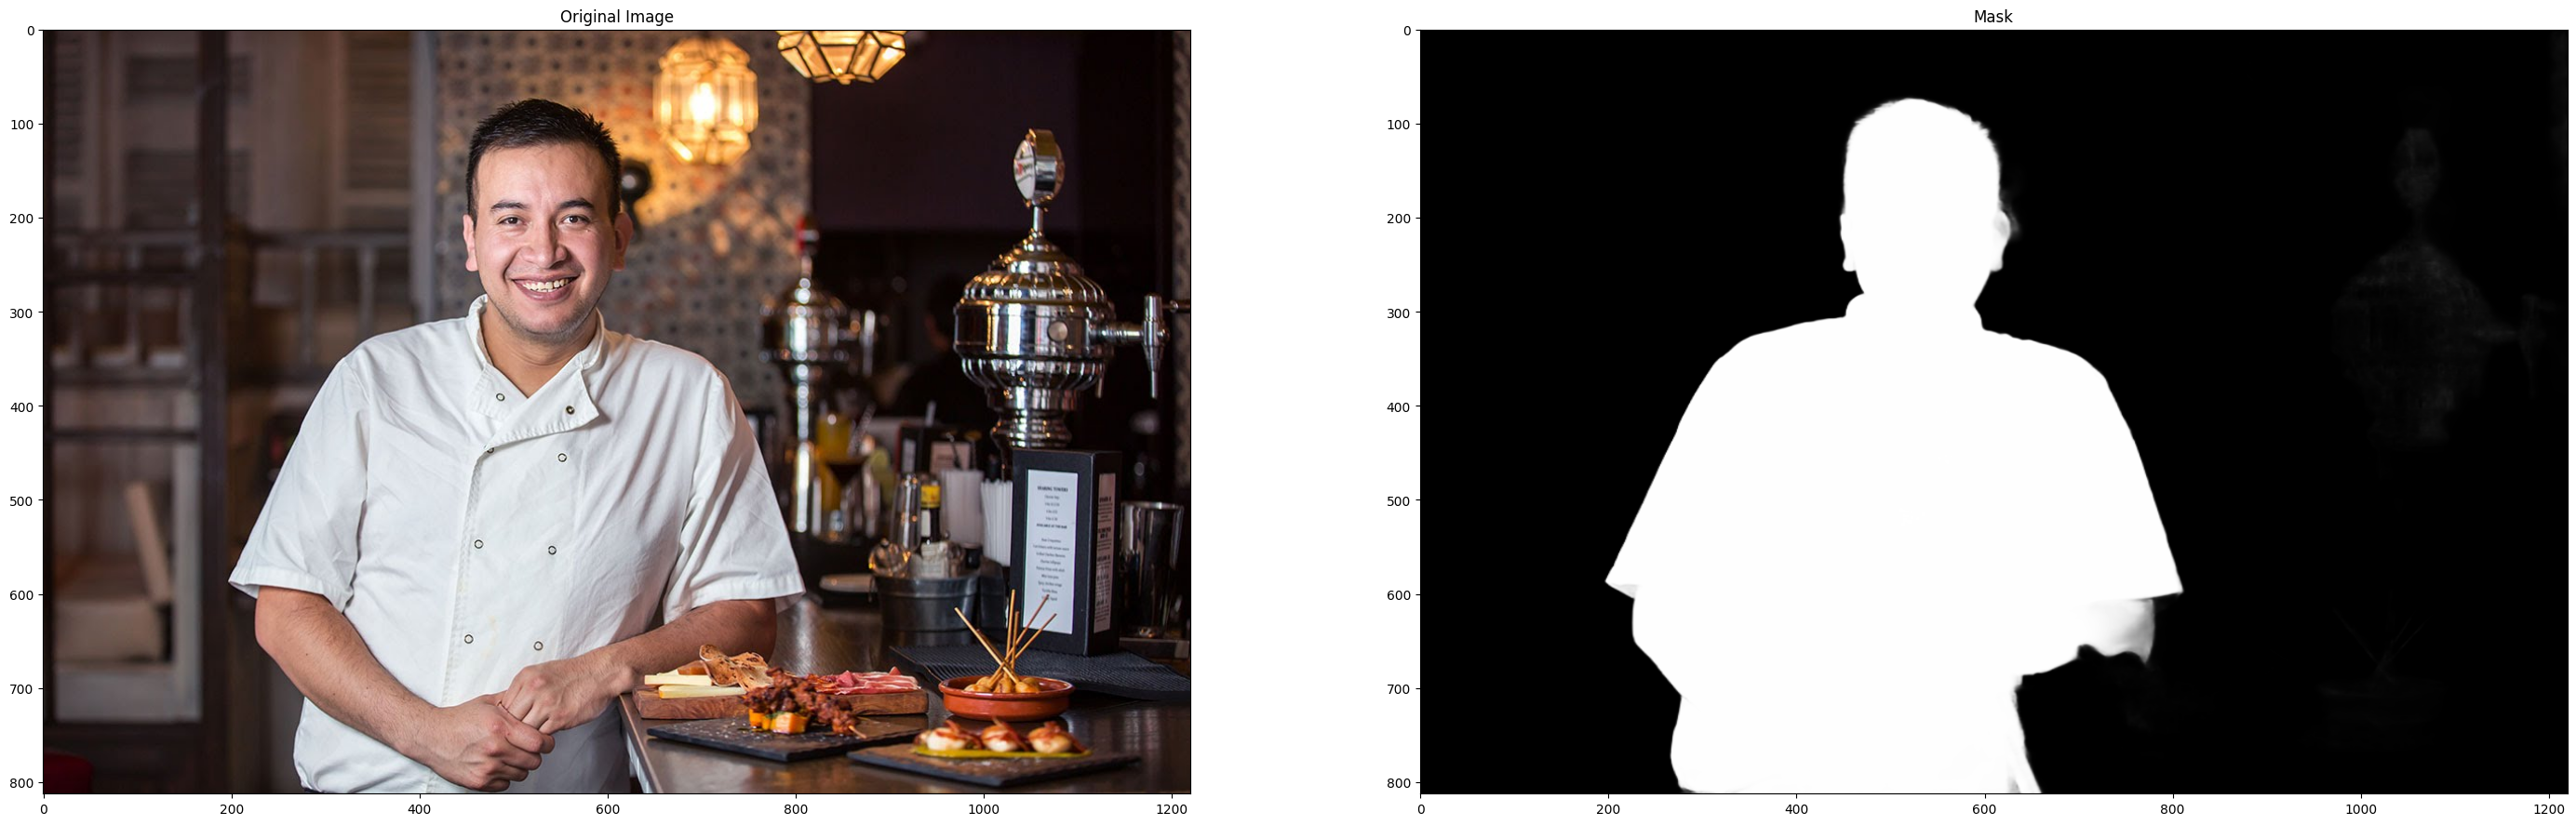

In [15]:
#image_path = "https://i5.walmartimages.com/asr/43995148-22bf-4836-b6d3-e8f64a73be54.5398297e6f59fc510e0111bc6ff3a02a.jpeg"
#image_path = "./demo_datasets/your_dataset/cld-sample-3.jpeg"
image_path = "./demo_datasets/your_dataset/kitchen-bar.jpeg"

#image_bytes = BytesIO(requests.get(image_path).content)
image_bytes = open(image_path, "rb")
image_tensor, orig_size = load_image(image_path, hypar) 
mask = predict(net,image_tensor,orig_size, hypar, device)
f, ax = plt.subplots(1,2, figsize = (35,20))

ax[0].imshow(np.array(Image.open(image_bytes))) # Original image
ax[1].imshow(mask, cmap = 'gray') # retouched image

ax[0].set_title("Original Image")
ax[1].set_title("Mask")

plt.show()

im = Image.fromarray(mask)
im.save("./demo_datasets/your_dataset_result/kitchen-bar_mask.jpeg")